## **Active Learning**

Using `twinLab`, we can easily build a surrogate model of some real-world physical processes using limited experimental data. The discrepancy between this surrogate model and the real process is described by the (calibrated) uncertainty estimate produced our models. This way, inference activities while using the surrogate model can be supported by well-grounded evidence of the model *correctness*. In areas of high model uncertainty, one must then take care to not be overly trusting of the model output, which is especially important for safety-critical applications.

In scenarios of high model uncertainty, one useful activity is to improve the model by collecting additional data. Here, **Active Learning** (also known as *Design of Experiments* or *Optimal Experimental Design*) as it is presented in `twinLab` answers the question of how best to obtain new experimental data, in order to build a surrogate which is *most accurate* while *requiring the least amount of data*. 

This notebook will cover: 
- Using Active Learning to iteratively improve a surrogate model in `twinLab`

In [ ]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# twinLab import
import twinlab as tl

### **1-Dimensional example**

We first begin with a one-dimensional example. Consider the following function:

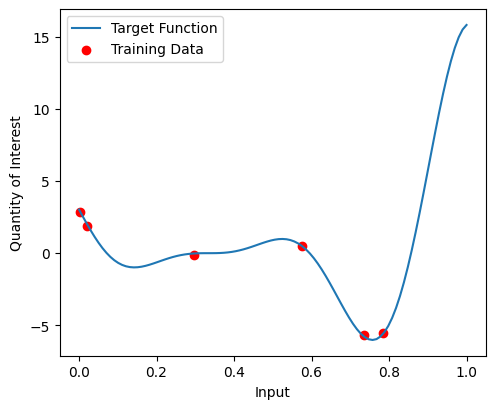

In [2]:
# Target function: forrester function
def f(x, a=6, b=12):
    return (a*x - 2)**2 * np.sin(b*x -4)

X = np.linspace(0,1,100)[:,np.newaxis]
y = f(X) # Arrange outputs as feature columns

# Set up training data dataframe 
n_train = 6
X_data = np.random.uniform(0, 1, size=n_train)
y_data = f(X_data) + np.random.normal(scale=0.1, size=X_data.shape)

# Plot
plt.figure(figsize=(5.5, 4.5))
plt.plot(X,y, label="Target Function")
plt.scatter(X_data, y_data, color="red", label="Training Data")
plt.xlabel("Input")
plt.ylabel("Quantity of Interest")
plt.legend()
plt.show()

Imagine that the process to obtain this training data was so painstaking that we only managed 6 data samples from initial experiments. The (material or computational) costs may be prohibitively expensive to obtain many more experiments, but we would like to model this (very limited) experimental data nonetheless. We now use `tl.train_campaign` to build an initial surrogate: 

In [3]:
# Convert to DataFrame
df_train = pd.DataFrame({'X': X_data, 'y': y_data})
df_test = pd.DataFrame({'X': X.flatten(), 'y': y.flatten()})

# Define the name of the dataset
dataset_id = "Training_Data"

# Upload the dataset to the cloud
tl.upload_dataset(df_train, dataset_id, verbose=True)

Dataframe is uploading.
Processing dataset.
Dataset Training_Data was processed.


In [4]:
# Initialise campaign
campaign_id = "BasicGP"

campaign_params = {
    "dataset_id": dataset_id,                   
    "inputs": ["X"],                          
    "outputs": ["y"],
}                                        

# Start a new campaign and train a surrogate model
tl.train_campaign(campaign_params, campaign_id, verbose=True)

# Plot inference results
df_mean, df_stdev = tl.predict_campaign(df_test, campaign_id)
y_mean, y_stdev = df_mean.values, df_stdev.values

Model BasicGP has begun training.


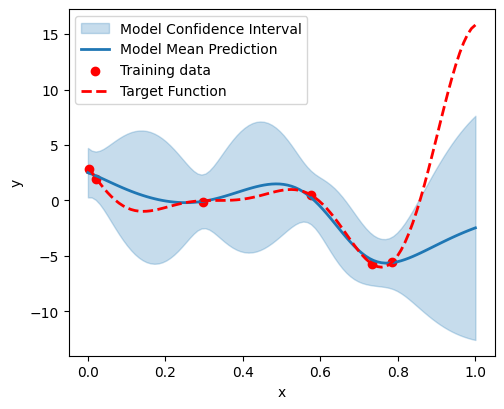

In [5]:
plt.figure(figsize=(5.5, 4.5))
plt.fill_between(X.flatten(), 
                 (y_mean - 2.58*y_stdev).flatten(), 
                 (y_mean + 2.58*y_stdev).flatten(), 
                 color='C0', alpha=0.25, label="Model Confidence Interval")
plt.plot(X, y_mean, c='C0', linewidth=2, label="Model Mean Prediction")

plt.scatter(df_train['X'], df_train['y'], color="red", label="Training data")
plt.xlabel('x'); plt.ylabel('y')

plt.plot(X, y, c='r', linewidth=2, linestyle='dashed', label="Target Function")
plt.legend()
plt.show()

Not a bad statistical model of 6 data samples, however we can see that the model does not line up exactly right with the true function in some areas. In this one-dimensional example, a human observer can pretty easily see that a new data sample should be obtained around `x=0.8`. However, when each data sample is so expensive to obtain, 'around' `x=...` may not be a good enough estimate. Furthermore, above two output dimensions it becomes very difficult for the human observer to visualise the model uncertainty. 

The short explanation of our Bayesian active learning algorithm is that it programmatically suggests the locations where the model uncertainty is highest, and suggest these as the new sample locations. First we will write a script defining an iteration of the following active learning loop: 

1. Build surrogate on currently available data
2. Call `tl.active_learn_campaign(campaign_id, num_points=n)`, with `n` being the number of desired sample locations.
3. Collect data at suggested locations (from experiment or simulator codes)
4. Add new data to currently available data

Steps (1) to (4) can be repeated infinitely, or more likely until the sampling budget is exhausted or the surrogate model passes some metric of accuracy.

In [6]:
# Write a helper function
def active_learning(df_train, df_test=df_test, campaign_id=campaign_id, num_samples=1):
    X_test = df_test["X"].values

    # Get current model predictions 
    df_mean, df_stdev = tl.predict_campaign(df_test, campaign_id)
    y_mean, y_stdev = df_mean.values.flatten(), df_stdev.values.flatten()

    # Compute optimal sample location(s)
    df_new = tl.active_learn_campaign(campaign_id, num_points=num_samples)
    print("Suggested Data Point(s):")
    display(df_new)
    # Evaluate new data points   
    df_new['y'] = f(df_new['X'].values) + np.random.normal(scale=0.1, size=num_samples)

    # Plot current model predictions
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4.5))

    # Plot the previous trained model and the suggested data point(s)
    ax1.fill_between(X_test, y_mean+2.58*y_stdev, y_mean-2.58*y_stdev, color="C0", alpha=0.25, label="Model Confidence Bound")
    ax1.plot(df_test["X"], y_mean, color="C0", label="Mean Prediction")
    ax1.scatter(df_train["X"], df_train["y"], color="red", label="Training Data")
    ax1.plot(df_test["X"], df_test["y"], color="red", linestyle="dashed", label="Target Function")
    ax1.vlines(df_new["X"], ymin=-10, ymax=20, color="gray", linestyle="dashed", alpha=0.8, label="Recommended sample location")
    ax1.set_title('Current Model')
    ax1.set_xlim(0, 1)
    ax1.set_xlabel("Input")
    ax1.set_ylabel("Quantity of Interest")
    # ax1.legend(loc="upper left")

    # Train model with new data
    df_train = pd.concat([df_train, df_new], ignore_index=True)

    # Upload training dataframe
    dataset_id = "Training_Data"

    tl.upload_dataset(df_train, dataset_id, verbose=True)

    campaign_params = {
    "dataset_id": dataset_id,                
    "inputs": ["X"],                           
    "outputs": ["y"],
    }                                        

    # Start a new campaign and train a surrogate model
    tl.train_campaign(campaign_params, campaign_id, verbose=True)
    
    # Plot model output with new data point(s)
    df_mean, df_stdev = tl.predict_campaign(df_test, campaign_id)
    y_mean, y_stdev = df_mean.values.flatten(), df_stdev.values.flatten()
    ax2.fill_between(df_test["X"], y_mean+2.58*y_stdev, y_mean-2.58*y_stdev, color="C0", alpha=0.25, label="Confidence Bound")
    ax2.plot(df_test["X"], y_mean, color="C0", label="Mean Prediction")
    ax2.scatter(df_train["X"][:-num_samples], df_train["y"][:-num_samples], color="red", label="Training Data")
    ax2.plot(df_test["X"], df_test["y"], color="red", linestyle="dashed", label="Target Function")
    ax2.scatter(df_train["X"][len(df_train)-num_samples:], df_train["y"][len(df_train)-num_samples:], color="gray", label="Recommended Sample")
    ax2.set_title('Next Model')
    ax2.set_xlim(0, 1)
    ax2.set_xlabel("Input")
    ax2.set_ylabel("Quantity of Interest")
    ax2.legend(loc="upper left")

    plt.show()

    return df_train, campaign_id

With this script, we can now run an iteration of the active learning loop:

Suggested Data Point(s):


,X
0,0.167847


Dataframe is uploading.
Processing dataset.
Dataset Training_Data was processed.
Model BasicGP has begun training.


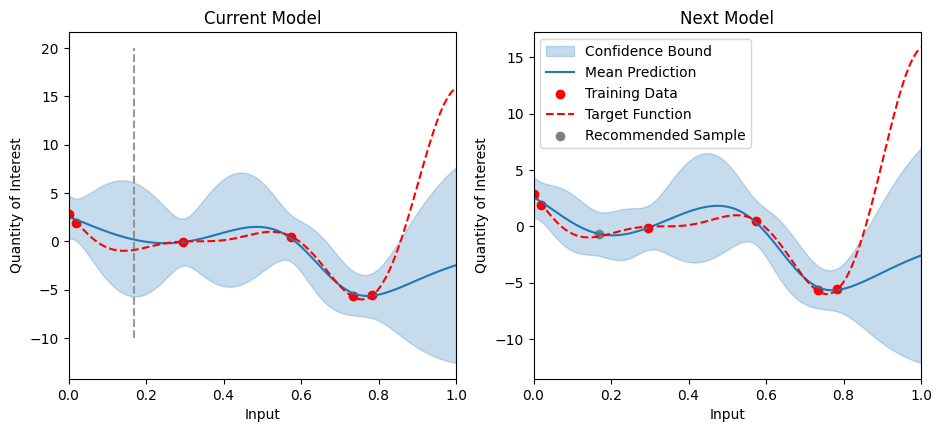

In [7]:
df_train, campaign_id = active_learning(df_train, df_test=df_test, campaign_id=campaign_id, num_samples=1)

Our algorithm suggests that the next location to sample is `x=0.765`. Already, the model is much better than before. If we can afford to, we may request another sample location, or stop here. 

In [8]:
# Delete the campaign and dataset
tl.delete_campaign("BasicGP")
tl.delete_dataset("Training_Data")

### **2-Dimensional Example**

Even in the previous one-dimensional example, it is difficult for a human observer to accurately determine the location of maximal model uncertainty. In this example, we demonstrate the difficulty of scaling up the 'human expert' with a two-dimensional example. 

In [9]:
# Define a non-linear, 2D function
def target_function(x, y):
    # Branin function
    a = 1
    b = 5.1 / (4 * np.pi ** 2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    return (
        a * (y - b * x ** 2 + c * x - r) ** 2
        + s * (1 - t) * np.cos(x)
        + s
    )


# Plotting function
def plot_function(
    xx, yy, zz,  # Background grid
    zz_pred=None, zz_stdv=None, # Mean and uncertainty in model function
    x_org=None, y_org=None, z_org=None,  # Original training data
    x_new=None, y_new=None, z_new=None,  # New training data
    x_upd=None, y_upd=None,  # Proposed candidate points
    show_truth=True,  # Show true function
    ):

    cmap_fn, cmap_std = 'YlGn', 'Blues'
    alpha_fn, alpha_std = 0.8, 1.
    levels = 20
    color_org, color_new, color_upd = 'black', 'blue', 'red'
    marker_org, marker_new, marker_upd = 'x', 'x', 'x'
    marker_col = 'o'
    vmin, vmax = zz.min(), zz.max()
    figx, figy = 4, 4

    # Set layout
    if zz_pred is None and zz_stdv is None:
        rows, cols = 1, 1
    else:
        rows, cols = 1, 3
    _, axs = plt.subplots(rows, cols, figsize=(cols*figx, rows*figy))

    if rows == 1 and cols == 1:
        axs = np.array([axs])
    axs = np.atleast_2d(axs)
    for ax in axs.flatten():
        ax.set_xticks([]), ax.set_yticks([])
        ax.set_aspect('equal')

    # Plot true function
    if show_truth:
        axs[0, 0].set_title('True function')
        axs[0, 0].contourf(xx, yy, zz, cmap=cmap_fn, levels=levels, alpha=alpha_fn, vmin=vmin, vmax=vmax)
    else:
        axs[0, 0].set_title('True function (unknown)')
        axs[0, 0].set_facecolor('lightgrey')
    
    if x_org is not None and y_org is not None and z_org is not None: # Plot original points
        if show_truth:
            axs[0, 0].scatter(x_org, y_org, c=color_org, marker=marker_org, label='Original samples')
        else:
            axs[0, 0].scatter(x_org, y_org, c=z_org, marker=marker_col, cmap=cmap_fn, vmin=vmin, vmax=vmax, label='Original samples')
        axs[0, 0].legend(loc="upper left")

    if x_new is not None and y_new is not None and z_new is not None: # Plot new points
        color = color_new if show_truth else z_new
        marker = marker_new if show_truth else marker_col
        axs[0, 0].scatter(x_new, y_new, c=color, marker=marker, cmap=cmap_fn, vmin=vmin, vmax=vmax)
        axs[0, 0].legend(loc="upper left")

    # Plot mean prediction
    if zz_pred is not None and zz_stdv is not None:
        axs[0, 1].set_title('Model function')
        axs[0, 1].contourf(xx, yy, zz_pred, cmap=cmap_fn, levels=levels, alpha=alpha_fn, vmin=vmin, vmax=vmax)
        axs[0, 2].set_title('Model uncertainty')
        axs[0, 2].contourf(xx, yy, zz_stdv, cmap=cmap_std, levels=levels, alpha=alpha_std)
        if x_org is not None: # Plot original points
            axs[0, 1].scatter(x_org, y_org, c=color_org, marker=marker_org)
            axs[0, 2].scatter(x_org, y_org, c=color_org, marker=marker_org)
            if rows == 2:
                axs[1, 1].scatter(x_org, y_org, c=color_org, marker=marker_org)
                axs[1, 2].scatter(x_org, y_org, c=color_org, marker=marker_org)
        if x_new is not None: # Plot new points
            axs[0, 1].scatter(x_new, y_new, c=color_new, marker=marker_new, label='New samples')
            axs[0, 2].scatter(x_new, y_new, c=color_new, marker=marker_new)
            if rows == 2:
                axs[1, 1].scatter(x_new, y_new, c=color_new, marker=marker_new)
                axs[1, 2].scatter(x_new, y_new, c=color_new, marker=marker_new)
            axs[0, 1].legend(loc="upper left")
        if x_upd is not None: # Plot candidate points
            axs[0, 2].scatter(x_upd, y_upd, c=color_upd, marker=marker_upd, label='Recommended future samples')
            axs[0, 2].legend(loc="upper left")
            if rows == 2:
                axs[1, 2].scatter(x_upd, y_upd, c=color_upd, marker=marker_upd)
    
    plt.tight_layout()
    plt.show()

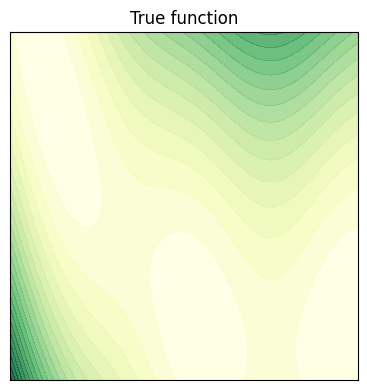

In [10]:
# Seed the random-number generator
seed = 4
np.random.seed(seed)
nmesh = 101
xmin, xmax = -5, 10
ymin, ymax = 0, 15

# Generate a grid of points and evaluate the function at each point
x, y = np.linspace(xmin, xmax, nmesh), np.linspace(ymin, ymax, nmesh)
xx, yy = np.meshgrid(x, y)
zz = target_function(xx, yy)

# Generate noisy train data
n_train = 9
err = 0.1
x_train = np.random.uniform(xmin, xmax, n_train)
y_train = np.random.uniform(ymin, ymax, n_train)
z_train = np.random.normal(target_function(x_train, y_train), err, n_train)

# Number of new data points to generate each iteration
n_candidates = 3

# Plot the data points
plot_function(xx, yy, zz, x_org=x_train, y_org=y_train)

# Convert to dataframes
df_train = pd.DataFrame({'x': x_train.flatten(), 'y': y_train.flatten(), 'z': z_train.flatten()})
df_test = pd.DataFrame({'x': xx.flatten(), 'y': yy.flatten(), 'z': zz.flatten()})

In [11]:
# Define the name of the dataset
dataset_id = "2DActive_Data"

# Upload the dataset to the cloud
tl.upload_dataset(df_train, dataset_id, verbose=True)

Dataframe is uploading.
Processing dataset.
Dataset 2DActive_Data was processed.


In [12]:
# Initialise campaign
campaign_id = "2DActiveGP"

campaign_params = {
    "dataset_id": dataset_id,                  
    "inputs": ['x','y'],                        
    "outputs": ['z'],
}                                        

# Start a new campaign and train a surrogate model
tl.train_campaign(campaign_params, campaign_id, verbose=True)

# Plot inference results
df_mean, df_stdev = tl.predict_campaign(df_test, campaign_id)
y_mean, y_stdev = df_mean.values, df_stdev.values

Model 2DActiveGP has begun training.


Now we can write our loop function...

In [13]:
def suggest_sample(campaign_id, df_train, df_test, n_candidates, df_new=None, show_truth=True):

    # Plot inference results
    df_mean, df_stdev = tl.predict_campaign(df_test, campaign_id)
    z_mean, z_stdv = df_mean.values, df_stdev.values

    x_org, y_org, z_org = df_train['x'].values, df_train['y'].values, df_train['z'].values
    if df_new is not None:
        x_new, y_new = df_new['x'].values, df_new['y'].values
        z_new = df_new['z'].values
    else:
        x_new, y_new, z_new = None, None, None

    # Get new candidate points
    candidates = tl.active_learn_campaign(campaign_id, num_points=n_candidates).values
    x_upd, y_upd = candidates[:, 0], candidates[:, 1]

    # Plot sample location
    plot_function(xx, yy, zz, 
                  z_mean.reshape((nmesh, nmesh)), z_stdv.reshape((nmesh, nmesh)),
                  x_org=x_org, y_org=y_org, z_org=z_org,
                  x_new=x_new, y_new=y_new, z_new=z_new,
                  x_upd=x_upd, y_upd=y_upd,
                  show_truth=show_truth,
                  )

    # Sample at new location(s)
    z_upd = np.random.normal(target_function(x_upd, y_upd), 0.1)

    # Add new sample(s) to training data
    df_upd = pd.DataFrame({'x': x_upd, 'y': y_upd, 'z': z_upd})
    df_train = pd.concat([df_train, df_upd])



    tl.upload_dataset(df_train, "New_Points")

    # Initialise campaign
    campaign_params = {
        "dataset_id": "New_Points",                  
        "inputs": ['x','y'],                       
        "outputs": ['z'],
    }                                        

    #   Start a new campaign and train a surrogate model
    tl.train_campaign(campaign_params, campaign_id, verbose=True)
    return campaign_id, df_train

... and request the first set of candidate points.

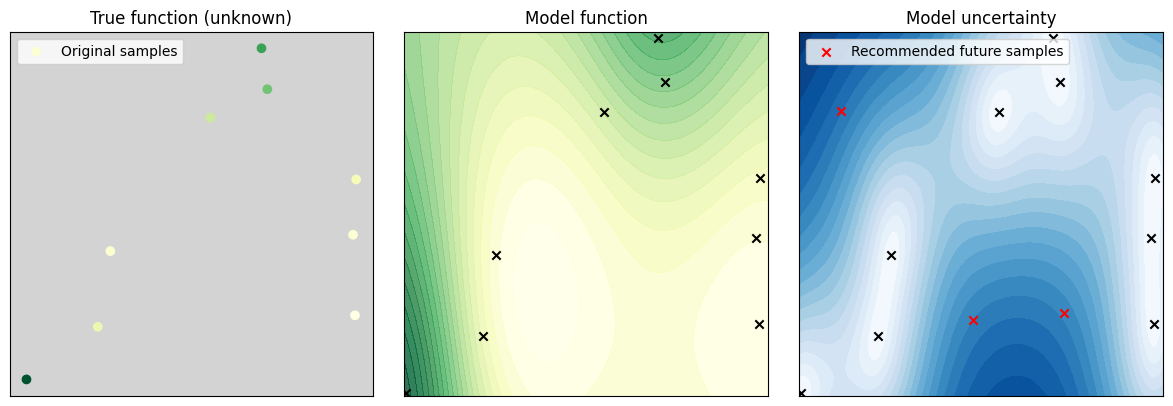

Model 2DActiveGP has begun training.


In [14]:
# Request a first set of candidates
gp_campaign, _df_train = suggest_sample("2DActiveGP", df_train, df_test, n_candidates=n_candidates, show_truth=False)
df_new = _df_train[-3:]
df_train = _df_train

We can then request another set of points and view the impact of the last set.

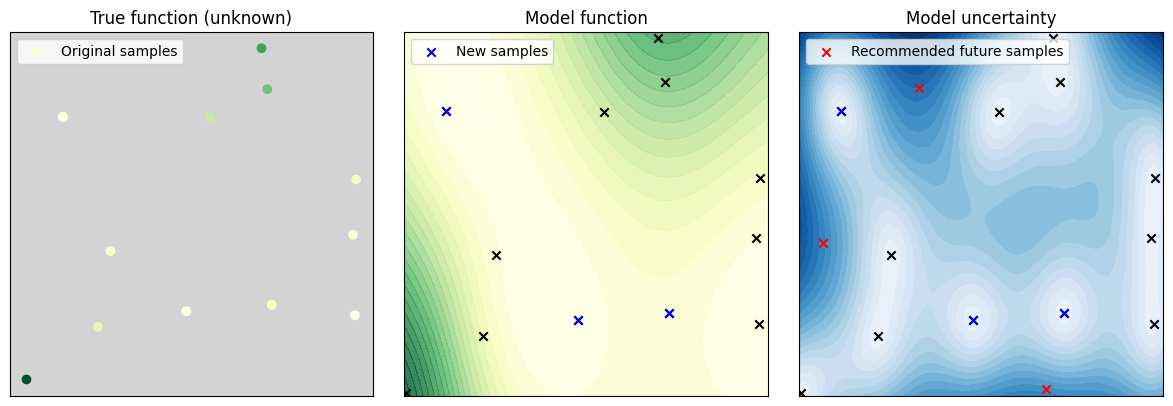

Model 2DActiveGP has begun training.


In [15]:
# Request another set of candidates
gp_campaign, df_train = suggest_sample("2DActiveGP", df_train, df_test, n_candidates=n_candidates, df_new=df_new, show_truth=False)

### **Error messaging for active learning**

In [16]:
print("Failing to specify any arguments:")
try:
    df_active = tl.active_learn_campaign()
except Exception as e:
    print(e)
print()

print("Failing to specify the number of points:")
try:
    df_active = tl.active_learn_campaign(campaign_id)
except Exception as e:
    print(e)
print()

print("Requesting a negative number of points:")
try:
    df_active = tl.active_learn_campaign(campaign_id, -1)
except Exception as e:
    print(e)
print()

print("Requesting zero points:")
try:
    df_active = tl.active_learn_campaign(campaign_id, 0)
except Exception as e:
    print(e)
print()

Failing to specify any arguments:
active_learn_campaign() missing 2 required positional arguments: 'campaign_id' and 'num_points'

Failing to specify the number of points:
active_learn_campaign() missing 1 required positional argument: 'num_points'

Requesting a negative number of points:
{'message': 'num_points must be positive'}
'dataframe not in API response body'

Requesting zero points:
{'message': 'num_points must be positive'}
'dataframe not in API response body'



In [18]:
# Delete campaign and dataset
tl.delete_campaign(campaign_id)

tl.delete_dataset("2DActive_Data")
tl.delete_dataset("Training_Data")
tl.delete_dataset("New_Points")